# A demonstration of using a neural network to obtain a cleaner sample of $B^0 \to K^{*0}\mu^+\mu^-$ decays

In [15]:
import h5py
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
import numpy as np

In [16]:
# Some helper functions
def getframe(fname):
    hdf5file = h5py.File(fname, "r")
    return hdf5file['events']

def stack(frame, column_names):
    arrays = [frame[name] for name in column_names]
    return np.stack(arrays, axis=1)

## Illustrate the variables in the data and plot a few

The data set contains the variables:
[('B0_DiraAngle', '<f8'), ('B0_ENDVERTEX_CHI2', '<f8'), ('B0_ENDVERTEX_NDOF', '<i4'), ('B0_OWNPV_X', '<f8'), ('B0_OWNPV_Y', '<f8'), ('B0_OWNPV_Z', '<f8'), ('B0_IPCHI2_OWNPV', '<f8'), ('B0_FDCHI2_OWNPV', '<f8'), ('B0_DIRA_OWNPV', '<f8'), ('B0_P', '<f8'), ('B0_PT', '<f8'), ('B0_MM', '<f8'), ('B0_BKGCAT', '<i4'), ('B0_TRUEID', '<i4'), ('B0_TAU', '<f8'), ('B0_relinfo_MU_SLL_ISO_1', '<f8'), ('B0_relinfo_MU_SLL_ISO_2', '<f8'), ('J_psi_ENDVERTEX_CHI2', '<f8'), ('J_psi_IPCHI2_OWNPV', '<f8'), ('J_psi_FDCHI2_OWNPV', '<f8'), ('J_psi_M', '<f8'), ('mu_plus_IPCHI2_OWNPV', '<f8'), ('mu_plus_P', '<f8'), ('mu_plus_PT', '<f8'), ('mu_plus_PIDmu', '<f8'), ('mu_plus_PIDK', '<f8'), ('mu_plus_PIDp', '<f8'), ('mu_plus_TRACK_GhostProb', '<f8'), ('mu_minus_P', '<f8'), ('mu_minus_PT', '<f8'), ('mu_minus_PIDmu', '<f8'), ('mu_minus_PIDK', '<f8'), ('mu_minus_PIDp', '<f8'), ('mu_minus_TRACK_GhostProb', '<f8'), ('K_P', '<f8'), ('K_PT', '<f8'), ('K_PIDmu', '<f8'), ('K_PIDK', '<f8')

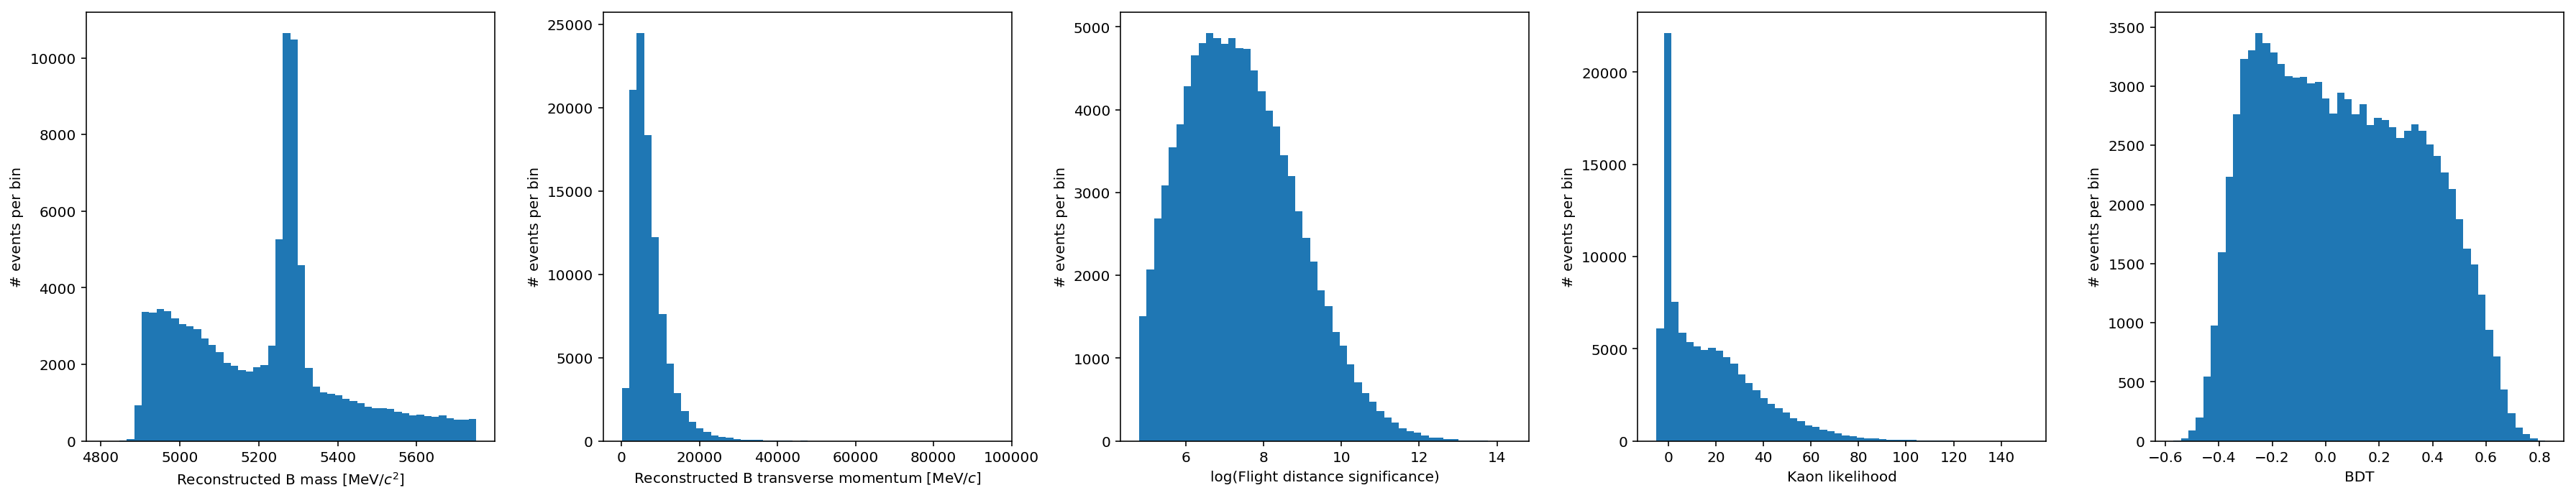

In [17]:
signalregion_frame = getframe("../../data/data.h5")

# Show what is inside the dataset
print("The data set contains the variables:")
print(signalregion_frame.dtype)

print("The BDT variable is the output of a Boosted Decision Tree which is another type of machine learning algorithm.")

fig = plt.figure(figsize=(25,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1, 5)

ax1.hist(signalregion_frame['B0_MM'], 50)
ax1.set_xlabel(r'Reconstructed B mass [MeV/$c^2$]')
ax1.set_ylabel(r'# events per bin')

ax2.hist(signalregion_frame['B0_PT'], 50)
ax2.set_xlabel(r'Reconstructed B transverse momentum [MeV/$c$]')
ax2.set_ylabel(r'# events per bin')

ax3.hist(np.log(signalregion_frame['B0_FDCHI2_OWNPV']), 50)
ax3.set_xlabel(r'log(Flight distance significance)')
ax3.set_ylabel(r'# events per bin')

ax4.hist(signalregion_frame['K_PIDK'], 50)
ax4.set_xlabel(r'Kaon likelihood')
ax4.set_ylabel(r'# events per bin')

ax5.hist(signalregion_frame['BDT'], 50)
ax5.set_xlabel(r'BDT')
ax5.set_ylabel(r'# events per bin')

plt.tight_layout()

## Setup a neural network using the Keras framework

In [18]:
# Prepare the data
vars = ['B0_DiraAngle', 'B0_ENDVERTEX_CHI2', 'mu_minus_PT', 'mu_plus_PT', 'K_PT', 'Pi_PT', 'B0_FDCHI2_OWNPV', 'B0_relinfo_MU_SLL_ISO_1', 'B0_IPCHI2_OWNPV']

uppersideband = stack(getframe("../../data/data-uppersideband.h5"), vars)
simulation = stack(getframe("../../data/simulation.h5"), vars)
n_uppersideband = uppersideband.shape[0]
n_simulation = simulation.shape[0]

# Label the background as 0 and the simulated signal as 1
uppersideband_labels = np.zeros(n_uppersideband)
simulation_labels = np.ones(n_simulation)

# Put it all together and create a training dataset and a testing dataset. Use 80% for training
n_uppersideband_split = int(0.8*n_uppersideband)
n_simulation_split = int(0.8*n_simulation)
trainingdata = np.concatenate((uppersideband[:n_uppersideband_split], simulation[:n_simulation_split]))
traininglabels = np.concatenate((uppersideband_labels[:n_uppersideband_split], simulation_labels[:n_simulation_split]))

testingdata = np.concatenate((uppersideband[n_uppersideband_split:], simulation[n_simulation_split:]))
testinglabels = np.concatenate((uppersideband_labels[n_uppersideband_split:], simulation_labels[n_simulation_split:]))

In [19]:
# Create the model

# Instantiate model
model = Sequential()

# The input layer
model.add(Dense(16, input_dim=trainingdata.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))

# A hidden layer
model.add(Dense(8, activation = 'relu'))

# The output layer
model.add(Dense(1, activation = 'sigmoid'))

# Build as a binary classification
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainingdata, traininglabels, epochs=10, batch_size=32, verbose=0)

## Use the trained model to validate on testing data and make prediction

In [21]:
# Evaluate model on on testing data and on the signal region
bkgoutput = model.predict(uppersideband[n_uppersideband_split:])
simoutput = model.predict(simulation[n_simulation_split:])
testingoutput = model.predict(testingdata)

signalregion = stack(signalregion_frame, vars)
sigoutput = model.predict(signalregion)

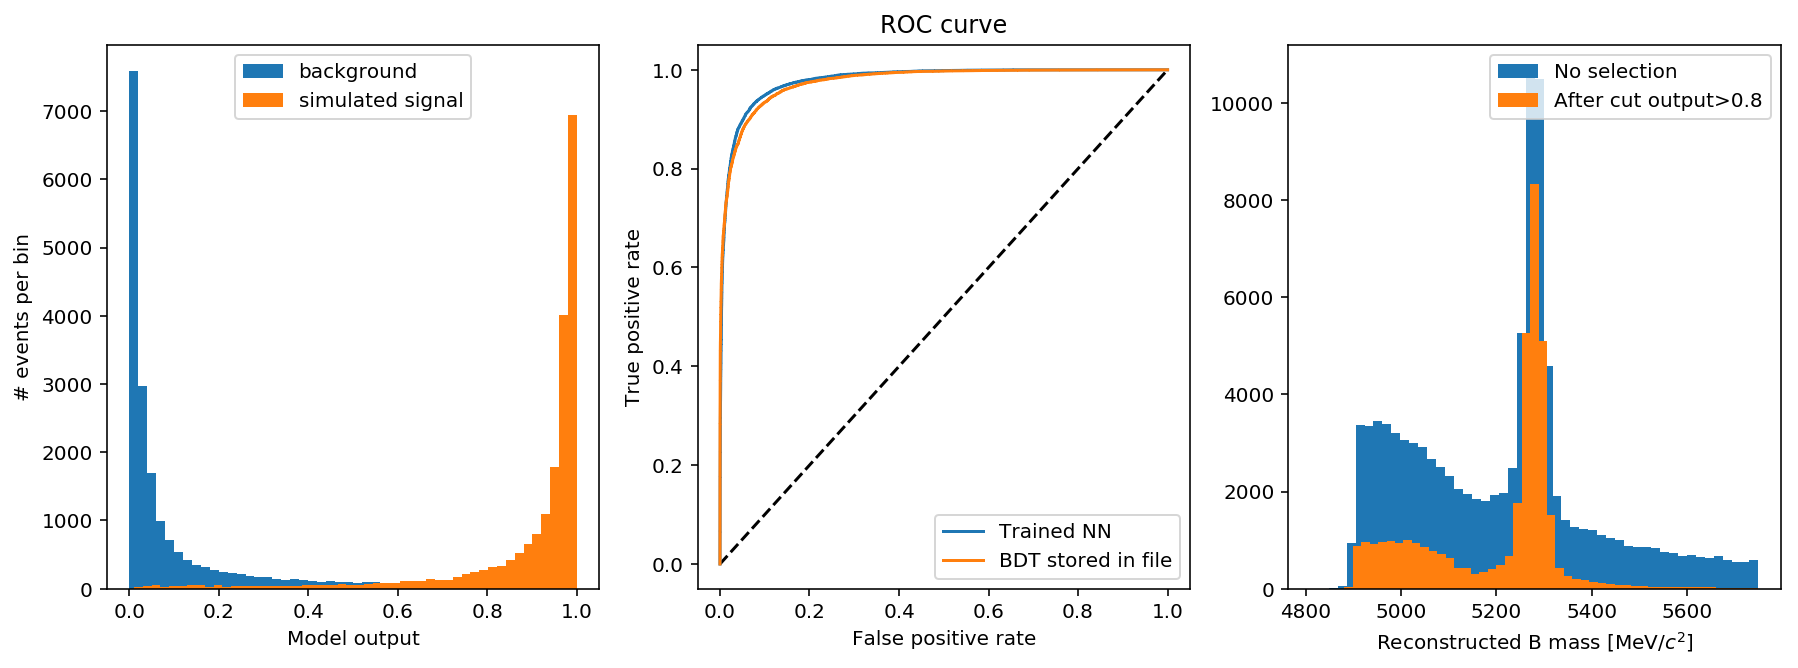

In [22]:
# Create some nice plots
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.hist(bkgoutput, 50, label='background')
ax1.hist(simoutput, 50, label='simulated signal')
ax1.legend()
ax1.set_xlabel(r'Model output')
ax1.set_ylabel(r'# events per bin')

# Create a ROC
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(testinglabels, testingoutput)
auc_keras = auc(fpr_keras, tpr_keras)

uppersidebandbdt = getframe("../../data/data-uppersideband.h5")['BDT'][n_uppersideband_split:]
simulationbdt = getframe("../../data/simulation.h5")['BDT'][n_simulation_split:]
bdttestingoutput = np.concatenate((uppersidebandbdt, simulationbdt))
fpr_BDT, tpr_BDT, thresholds_BDT = roc_curve(testinglabels, bdttestingoutput)
auc_BDT = auc(fpr_BDT, tpr_BDT)

ax2.plot([0, 1], [0, 1], 'k--')
ax2.plot(fpr_keras, tpr_keras, label='Trained NN')
ax2.plot(fpr_BDT, tpr_BDT, label='BDT stored in file')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title('ROC curve')
ax2.legend(loc='best')

# Let us reject anything with a value below 0.8 and see how it affects the signal mass peak
mask = (sigoutput < 0.8)
mass = signalregion_frame['B0_MM']
maskedmass = np.ma.masked_array(mass, mask)
ax3.hist(mass, 50, label='No selection')
ax3.hist(maskedmass[~maskedmass.mask], 50, label='After cut output>0.8')
ax3.legend()
ax3.set_xlabel(r'Reconstructed B mass [MeV/$c^2$]')
plt.show()


# Your exercise should start here

## Compare to a cut based analysis
Implement a single cut on the B0_PT variable and create a ROC curve for varying that cut. Plot it on top of the ROC curve for the NN above.

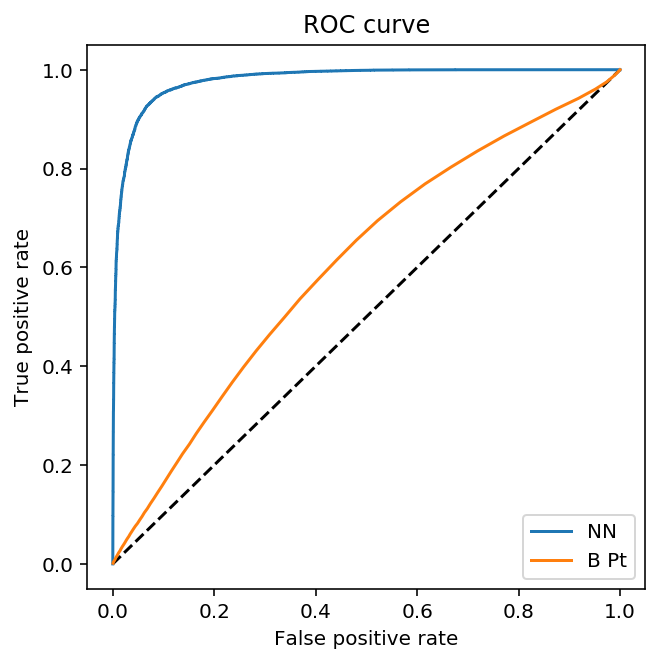

In [10]:
uppersidebandBPt = getframe("../../data/data-uppersideband.h5")['B0_PT']
simulationBPt = getframe("../../data/simulation.h5")['B0_PT']
n_uppersideband = len(uppersidebandBPt)
n_simulation = len(simulationBPt)
tpr_BPt = []
fpr_BPt = []
for ptcut in np.linspace(0., 40000, num=100):
    frac_uppersideband = (uppersidebandBPt>ptcut).sum()/n_uppersideband
    frac_simulation = (simulationBPt>ptcut).sum()/n_simulation
    tpr_BPt.append(frac_simulation)
    fpr_BPt.append(frac_uppersideband)

fig = plt.figure(figsize=(5,5))
ax1 = fig.subplots(1, 1)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(fpr_keras, tpr_keras, label='NN')
ax1.plot(fpr_BPt, tpr_BPt, label='B Pt')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve')
ax1.legend(loc='best')

It can be seen that selecting on a single variable is much less powerful. To cut down background by a factor 10 (so FPR=0.1) will give around a factor 5 less signal.

- <span style="color: red"> 2 marks: Extract the B Pt variable</span>
- <span style="color: red"> 2 marks: Create the ROC curve</span>
- <span style="color: red"> 2 marks: Add second variable.</span>
- <span style="color: red"> 2 marks: Draw conclusion.</span>

## Build your own NN

Create your own NN and train it. Use the code above as a template. Try to add in some of the particle identification (PID) variables. Report on what you find when comparing to the NN above. A good way to illustrate this would be to overlay your curve on the ROC curve plotted above.

In [11]:
# Prepare the data
vars = ['B0_DiraAngle', 'B0_ENDVERTEX_CHI2', 'mu_minus_PT', 'mu_plus_PT', 'K_PT', 'Pi_PT', 'B0_FDCHI2_OWNPV', 'B0_relinfo_MU_SLL_ISO_1', 'B0_IPCHI2_OWNPV', 'K_PIDK', 'mu_minus_PIDmu', 'mu_plus_PIDmu', 'Pi_PIDK']

uppersideband = stack(getframe("../../data/data-uppersideband.h5"), vars)
simulation = stack(getframe("../../data/simulation.h5"), vars)
n_uppersideband = uppersideband.shape[0]
n_simulation = simulation.shape[0]

# Label the background as 0 and the simulated signal as 1
uppersideband_labels = np.zeros(n_uppersideband)
simulation_labels = np.ones(n_simulation)

# Put it all together and create a training dataset and a testing dataset. Use 80% for training
n_uppersideband_split = int(0.8*n_uppersideband)
n_simulation_split = int(0.8*n_simulation)
trainingdata = np.concatenate((uppersideband[:n_uppersideband_split], simulation[:n_simulation_split]))
traininglabels = np.concatenate((uppersideband_labels[:n_uppersideband_split], simulation_labels[:n_simulation_split]))

testingdata = np.concatenate((uppersideband[n_uppersideband_split:], simulation[n_simulation_split:]))
testinglabels = np.concatenate((uppersideband_labels[n_uppersideband_split:], simulation_labels[n_simulation_split:]))

In [12]:
# Create the model

# Instantiate model
model = Sequential()

# The input layer
model.add(Dense(16, input_dim=trainingdata.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))

# A hidden layer
model.add(Dense(8, activation = 'relu'))

# The output layer
model.add(Dense(1, activation = 'sigmoid'))

# Build as a binary classification
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainingdata, traininglabels, epochs=10, batch_size=32, verbose=0)

In [14]:
# Evaluate model on on testing data and on the signal region
bkgoutput = model.predict(uppersideband[n_uppersideband_split:])
simoutput = model.predict(simulation[n_simulation_split:])
testingoutput = model.predict(testingdata)

signalregion = stack(signalregion_frame, vars)
sigoutput_PID = model.predict(signalregion)

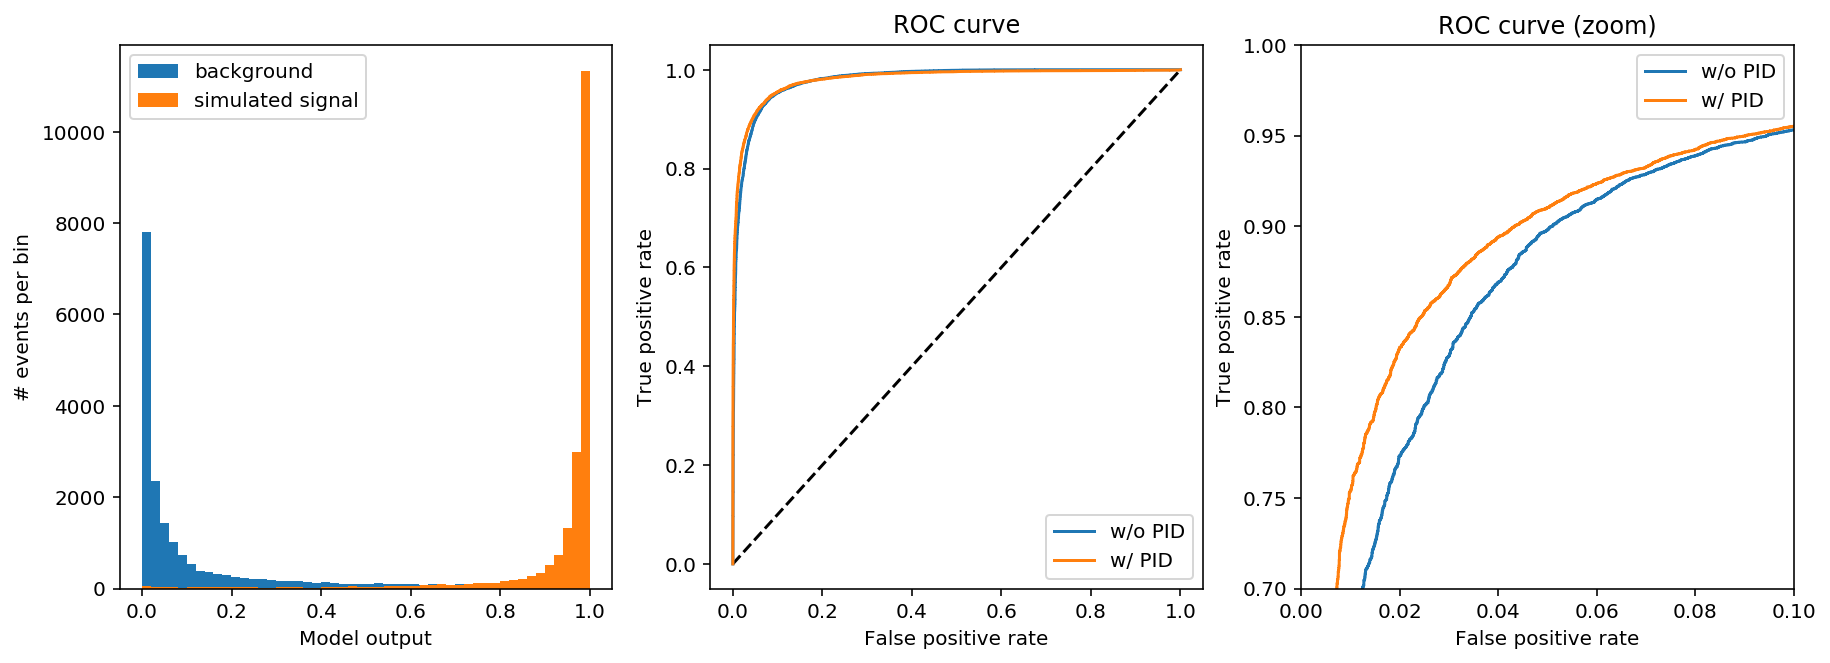

In [15]:
# Create some nice plots
fig = plt.figure(figsize=(15,5))
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.hist(bkgoutput, 50, label='background')
ax1.hist(simoutput, 50, label='simulated signal')
ax1.legend()
ax1.set_xlabel(r'Model output')
ax1.set_ylabel(r'# events per bin')

# Create a ROC
from sklearn.metrics import roc_curve, auc

fpr_keras_PID, tpr_keras_PID, thresholds_keras_PID = roc_curve(testinglabels, testingoutput)
auc_keras_PID = auc(fpr_keras_PID, tpr_keras_PID)

ax2.plot([0, 1], [0, 1], 'k--')
ax2.plot(fpr_keras, tpr_keras, label='w/o PID')
ax2.plot(fpr_keras_PID, tpr_keras_PID, label='w/ PID')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title('ROC curve')
ax2.legend(loc='best')

ax3.axis([0, 0.1, 0.7, 1])
ax3.plot(fpr_keras, tpr_keras, label='w/o PID')
ax3.plot(fpr_keras_PID, tpr_keras_PID, label='w/ PID')
ax3.set_xlabel('False positive rate')
ax3.set_ylabel('True positive rate')
ax3.set_title('ROC curve (zoom)')
ax3.legend(loc='best')

The code was copied from above and 4 different variables with PID information was added. Nothing else was changed. It can be seen that the performance is very similar but slightly better. The zoomed in plot illustrates the performance improvement better.

- <span style="color: red"> 2 marks: Add extra variables to neural network</span>
- <span style="color: red"> 2 marks: Train neural network</span>
- <span style="color: red"> 2 marks: Create ROC curve with comparison</span>
- <span style="color: red"> 2 marks: Draw conclusion.</span>

## Compare to the real world
Now try to create a ROC curve from the actrual data it will be applied to. So get an array of False Positive Rates (FPR) by looking at background events in the region between 5400 and 5600 MeV. For True Positive Rate (TPR), look at events in the peak between 5239 and 5319 MeV. You will need to estiamte the background under the peak, in order to work out the TPR. Compare this to the estimate of the ROC curve from the test sample and comment on any difference. Look at if the inclusion of PID variables in your NN affects your conclusions.

In [16]:
masses = signalregion_frame['B0_MM']

FPR_NN = []
TPR_NN = []
FPR_NN_PID = []
TPR_NN_PID = []

for cut in np.linspace(0.0, 1.0, 50):
    n_bkg = 0
    n_bkg_NN = 0
    n_bkg_NN_PID = 0
    n_sig = 0
    n_sig_NN = 0
    n_sig_NN_PID = 0
    n_bkg_low = 0
    n_bkg_high = 0

    for mass, NN, NN_PID in zip(masses, sigoutput, sigoutput_PID):
        if (mass > 5650 and mass < 5700):
            n_bkg_high += 1
        if (mass > 5429 and mass < 5479):
            n_bkg_low += 1
        if (mass > 5400 and mass < 5600):
            n_bkg += 1
            if NN > cut:
                n_bkg_NN += 1
            if NN_PID > cut:
                n_bkg_NN_PID += 1
        if (mass > (5279-40) and mass < (5279+40)):
            n_sig += 1
            if NN > cut:
                n_sig_NN += 1
            if NN_PID > cut:
                n_sig_NN_PID += 1
    k = (n_bkg_low / n_bkg_high)*80/200

    FPR_NN.append(n_bkg_NN / n_bkg)
    TPR_NN.append((n_sig_NN - k*n_bkg_NN) / (n_sig - k*n_bkg))
    FPR_NN_PID.append(n_bkg_NN_PID / n_bkg)
    TPR_NN_PID.append((n_sig_NN_PID - k*n_bkg_NN_PID) / (n_sig - k*n_bkg))

The number of events have been counted in a signal region (+-40 MeV around the peak at 5279 MeV), and a background region (5400 - 5600 MeV). In order to subtract the background under the signal, two assumptions are made to canculate the k factor above. The first one is that the background has an exponential shape (so the fractional increase in background when shifting a given number of MeV in mass is the same everywhere); the second assumption is that the shape of the background is not changing when the NN is applied.

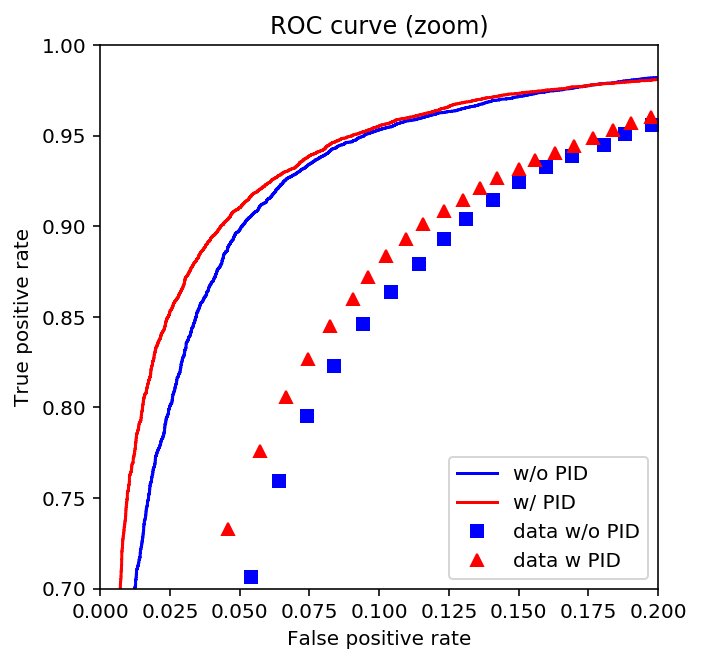

In [17]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.subplots(1, 1)

ax1.axis([0, 0.2, 0.7, 1])
ax1.plot(fpr_keras, tpr_keras, 'b', label='w/o PID')
ax1.plot(fpr_keras_PID, tpr_keras_PID, 'r', label='w/ PID')
ax1.plot(FPR_NN, TPR_NN, 'bs', label='data w/o PID')
ax1.plot(FPR_NN_PID, TPR_NN_PID, 'r^', label='data w PID')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve (zoom)')
ax1.legend(loc='best')

It can be seen from the plot above that the performance on data is not as good as what is predicted from the training. There can be two effects happening here
1. The background training was done on a sample that has a larger mass than what it is used for. If the sample has a mass dependence (coming through the momentum variables), this could be relevant.
2. The signal component is trained on a simulated sample. Any place where the simulation is not accurately reflecting the tru detector performance could lead to differences.

The difference between actual and predicted performance seems not to be particulary related to if the PID information is used or not.

- <span style="color: red"> 2 marks: Explain method to evaluate performance on data</span>
- <span style="color: red"> 2 marks: Implement background model</span>
- <span style="color: red"> 2 marks: Plot ROC curve on data.</span>
- <span style="color: red"> 2 marks: Draw conclusion</span>
